## AlexNet Model Training Porocess

In [16]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [17]:
train_path = 'split_data/train'
valid_path = 'split_data/val'
test_path = 'split_data/test'

### Training classes

In [18]:
train_classes = os.listdir(train_path)

### Training batch sizes

In [19]:
train_batch_size = 16
test_batch_size = 16
valid_batch_size = 16

### Training samples

In [20]:

# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 3161
Test samples: 657
Validation samples: 558


In [21]:
train_n = 3161
test_n = 657
valid_n = 558

### Training steps (per epoch)

In [22]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [23]:
epochs = 20

### Generate batches

In [24]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 3161 images belonging to 9 classes.
Found 558 images belonging to 9 classes.
Found 657 images belonging to 9 classes.


### Base model (AlexNet)

#### Training from scratch

In [25]:
base_model = tf.keras.applications.ResNet50(include_top=False,
    weights=None,
    pooling='avg')

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
output =  tf.keras.layers.Dense(len(train_classes), activation='softmax')(base_model.output)
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [28]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

### Generate new model

In [29]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [30]:
history = new_model.fit_generator(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[es_callback])

Epoch 1/20
197/197 [==============================] - 208s 1s/step - loss: 3.9821 - accuracy: 0.2639 - val_loss: 2.1642 - val_accuracy: 0.4945
Epoch 2/20
197/197 [==============================] - 193s 980ms/step - loss: 1.7308 - accuracy: 0.4846 - val_loss: 2.1609 - val_accuracy: 0.4375
Epoch 3/20
197/197 [==============================] - 194s 986ms/step - loss: 1.3091 - accuracy: 0.5860 - val_loss: 0.8442 - val_accuracy: 0.6526
Epoch 4/20
197/197 [==============================] - 192s 975ms/step - loss: 1.0588 - accuracy: 0.6696 - val_loss: 0.5871 - val_accuracy: 0.8125
Epoch 5/20
197/197 [==============================] - 182s 926ms/step - loss: 0.9968 - accuracy: 0.7005 - val_loss: 3.0550 - val_accuracy: 0.6268
Epoch 6/20
197/197 [==============================] - 194s 986ms/step - loss: 0.9350 - accuracy: 0.7221 - val_loss: 0.5246 - val_accuracy: 0.7904
Epoch 7/20
197/197 [==============================] - 191s 969ms/step - loss: 0.8221 - accuracy: 0.7692 - val_loss: 0.5526 - va

### Evaluate training process

In [2]:
results = new_model.evaluate_generator(train_batches, train_steps)
results

NameError: name 'new_model' is not defined

#### Loss function

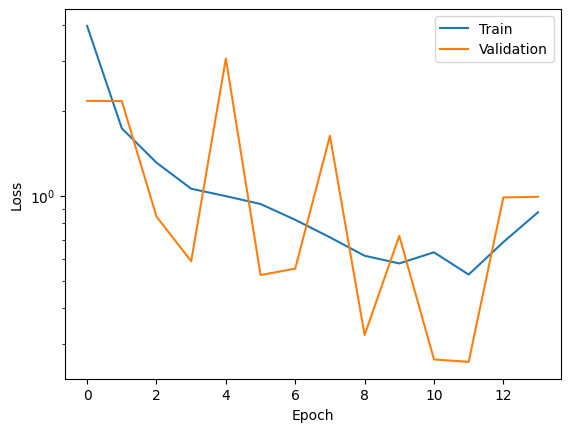

In [32]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

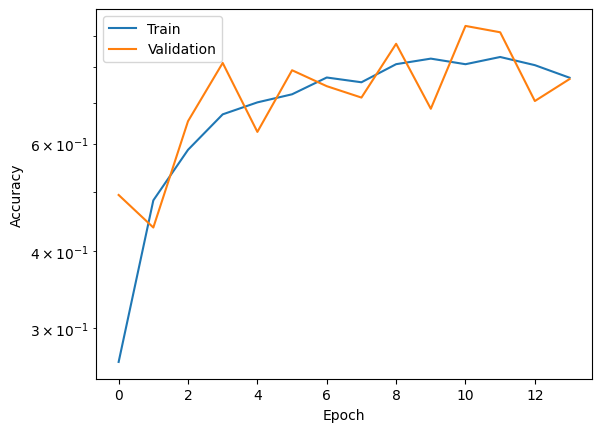

In [33]:
plt.semilogy(history.epoch, history.history['accuracy'], label='Train')
plt.semilogy(history.epoch, history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
Y_train_pred =new_model.predict_generator(train_batches,train_steps)

In [35]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

In [36]:
print(len(train_batches.classes))
print(len(y_train_pred))

3161
3152


#### Confusion matrix

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming train_batches is your training data generator
# Make predictions on the training set
y_train_pred = new_model.predict(train_batches, steps=train_batches.samples // train_batches.batch_size + 1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Ensure the lengths match
assert len(train_batches.classes) == len(y_train_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm_train = confusion_matrix(train_batches.classes, y_train_pred_classes)

print(cm_train)

# cm_train = confusion_matrix(train_batches.classes, y_train_pred)

198/198 [==============================] - 186s 939ms/step
[[38 26 39 41 33 35 38 43 57]
 [41 16 51 42 30 37 54 25 57]
 [39 29 55 35 22 48 38 39 49]
 [44 29 48 30 32 50 39 36 40]
 [38 29 39 41 43 34 43 37 44]
 [34 17 50 41 33 38 40 40 59]
 [39 32 57 25 29 41 36 36 57]
 [51 18 42 41 30 30 45 46 51]
 [38 27 53 34 25 43 35 40 55]]


Text(0.5, 135.7222222222222, 'Predicted label')

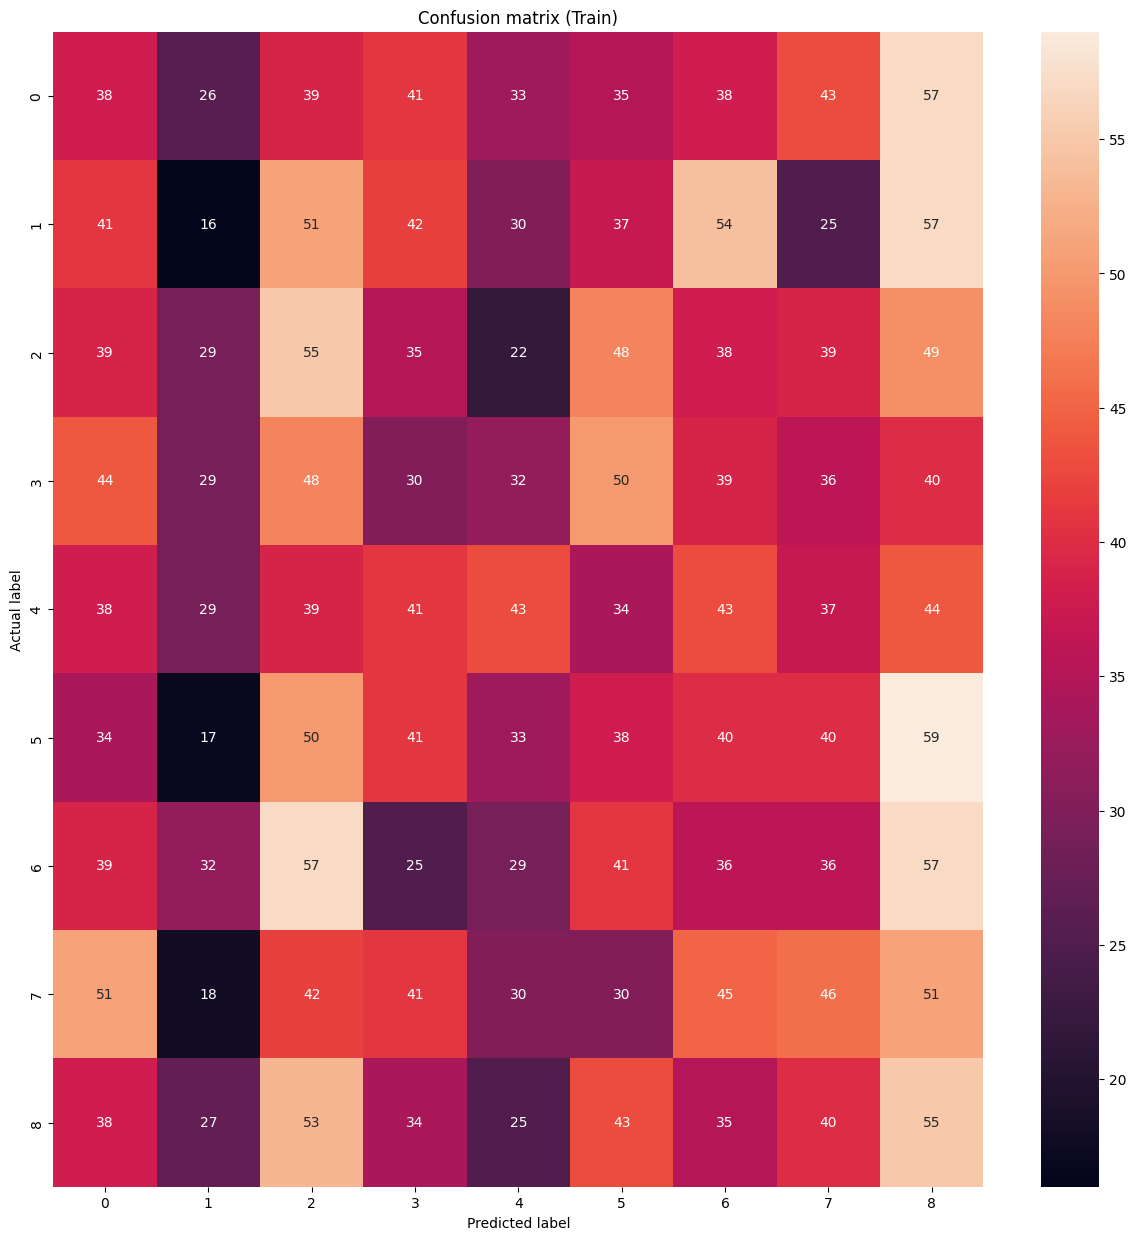

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [39]:
Y_pred =new_model.predict_generator(test_batches,test_steps)

In [40]:
y_pred = np.argmax(Y_pred, axis=1)

In [41]:
# cm = confusion_matrix(test_batches.classes, y_pred)

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_batches is your test data generator
# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm = confusion_matrix(test_batches.classes, y_pred_classes)

print(cm)

42/42 [==============================] - 38s 908ms/step
[[ 7  6 13  3 10 14  5  8  7]
 [14  3  6  8  5  7 12  5 14]
 [ 9  5  8  8  5 10 11  7 10]
 [ 8  2  9  6 10  7 11  8 12]
 [12  9  9  4  3  7  6 11 11]
 [ 7  8 11 13  5  9  4  7  9]
 [10  4 13  9  5  4  8  6 14]
 [ 4  3 12  9  8 13  7  8  9]
 [ 6  5  9  7  5  4 16  8 13]]


Text(0.5, 135.7222222222222, 'Predicted label')

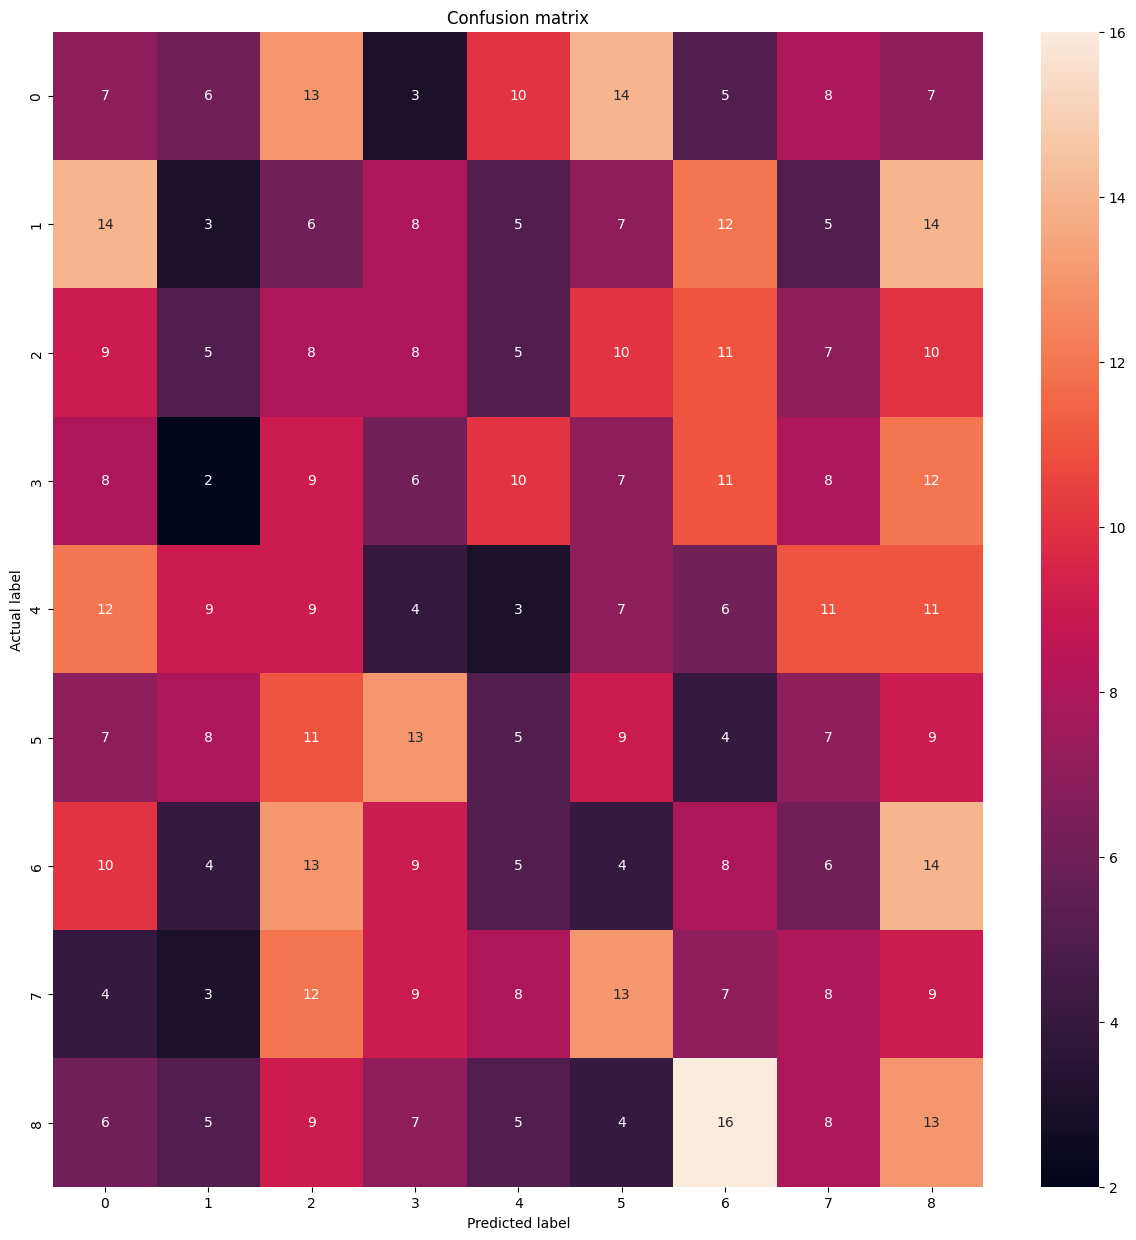

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Evaluate model on test set

In [1]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_steps)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

NameError: name 'new_model' is not defined

### Save model

In [43]:
new_model.save('resnet_new.h5')